# Gnutella Analysis

Gnutella was a p2p file sharing network from the early 2000s.
The network structure itself was a distributed alternative to
centralised file indexes, meaning it's purpose was to allow file querying,
i.e. answering the question: "is this file available on a computer
somewhere on the network and, if so, where?"

Thus "Gnutella" refers to at least two interesting networks:
- The network connections between computers allowing for querying.
- The network of who downloaded what from whom.

Our network is the former: Nodes are consumer laptops and desktops,
and edges are connections between these, representing paths through which
file request queries could move. The edges are directed (each computer had
a list of computers to which it would relay queries). With this in mind we
posed the following question of our data: **how robust is the Gnutella
network?**

We believe robustness is a relevant aspect of the network due to it
being an indication of how useful network was and of how hard
it would be to shut down (much of the activity on the network was
illegal file sharing).

Our data consists of nine snapshots of the network, crawled at different
days of August 2002, totalling to more than 190.000 nodes and about
500.000 edges. So as to make analysis more viable with the size of the
network in mind, we precomputed various network properties and stored
the results into .json files for quick use.

## Table of Contents
- [Imports](#mports)
- [Reading Data](#reading)
- [Analysis](#analysis)
    - [Degree Distribution](#degdist)
    - [Centrality](#centrality)
        - [Betweenness Centrality](#betweenness)
        - [Closeness Centrality](#closeness)
        - [Eigenvector Centrality](#eigenvector)
    - [Fitting](#fitting)
    - [Robustness](#robustness)



<a id='imports'></a>
## Imports
The following libraries were used in our analysis:

In [10]:
# native python
import json
import os
import warnings; warnings.filterwarnings("ignore")

# third party
from tqdm import tqdm
import powerlaw
import numpy as np

# plotting
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

<a id='reading'></a>

## Reading Data

We read in the precomputed .json files, constructing a dictionary `D` of
dictionaries of data for each of the 9 graphs. Each such dictionary has
the following structure:

**Insert structure**
- 'degs'
    - ['in']
    - ['out']
    - ['centrality']
- 'config'


In [14]:
def use_json():
    D = {}
    dumps = [f"../data/dumps/{target}" for target in sorted(os.listdir('../data/dumps/'))]
    for i in tqdm(range(len(dumps))):
        with open(dumps[i], 'r') as data_file:
            data = json.load(data_file)
            D[i] = data
    return D

D = use_json()

100%|██████████| 9/9 [00:00<00:00, 149.49it/s]


<a id='analysis'></a>

## Analysis

Initially we perform some exploratory data analysis,
plotting degree distributions, centrality measures,
and power law fitting. This is done to get a better understanding of what we are working with and look into potential problems that could arise in the future. Furthermore, getting a better understanding of the data also provides insight as to what we can do with it.

Lastly we plot the robustness
of the network by removing nodes using various heuristics.

As our network, in fact, is nine snapshots of Gnutella
at different points in time, our plots will consist of 9
subplots, so as to determine what remains true across the
time in focus and what does not.

With this intention in mind we create a plotter function.

In [21]:
def plotter(function):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    i = 0
    for ax in axes:
        for ay in ax:
            exec(f"{function}")
            ay.legend()
            i += 1
    plt.show()

<a id='degdist'></a>

### Degree distribution

We plot the degree distribution of each graph

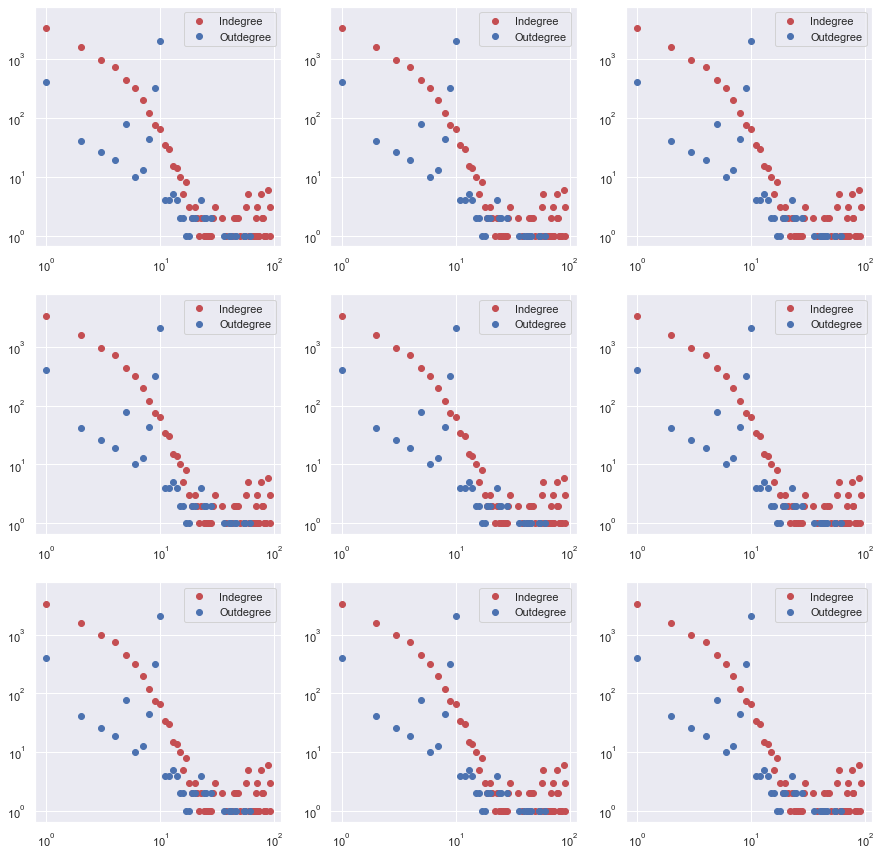

In [26]:
def degdist(ay):
    indeg = D[i]['degs']['in']
    outdeg = D[i]['degs']['out']
    ay.loglog(indeg[0], indeg[1], 'ro', label='Indegree')
    ay.loglog(outdeg[0], outdeg[1], 'bo', label='Outdegree')

plotter("degdist(ay)")

Blah blah blah blah blah blah

<a id='centrality'></a>

### Centrality Measuress


At the time of crawling the network, two gnutella protocols were in fact in place (0.4 and 0.6)
0.4 used query flooding and 0.6 used query routing. It is in unlcear to us what protocol
was running on the nodes in our network. We have thus plotted the centrality
measure that was relevant in either case.

As the plotting of centrality measures are largely the same,
we make a function

In [33]:
def centrality(kind, ay):
    orignal = D[i]['centrality'][kind]
    config = D[i]['C']['centrality'][kind]
    ay.loglog(orignal[0], orignal[1], 'ro', label='Original Graph')
    ay.loglog(config[0], config[1], 'bo', label='Configuration Model')

<a id='betweenness'></a>

#### Betweenness centrality

blah blah blach

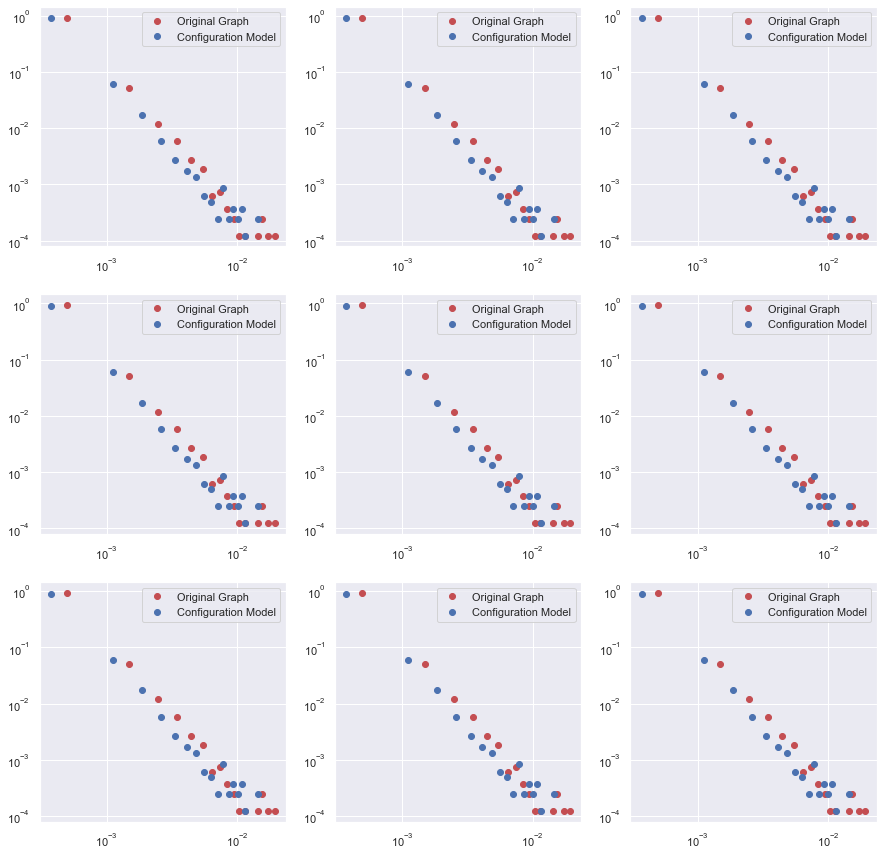

In [34]:
plotter('centrality("betweenness", ay)')

<a id='closeness'></a>

#### Closeness centrality

To the extent that the network is using query flooding to find files, closeness centrality is essential.
Therefor we have plotted it here.

In [ ]:
plotter('centrality("closeness", ay)')

<a id='eigenvector'></a>

#### Eigen vector centrality

To the extent that the network is using query flooding to find files, closeness centrality is essential.
Therefor we have plotted it here.

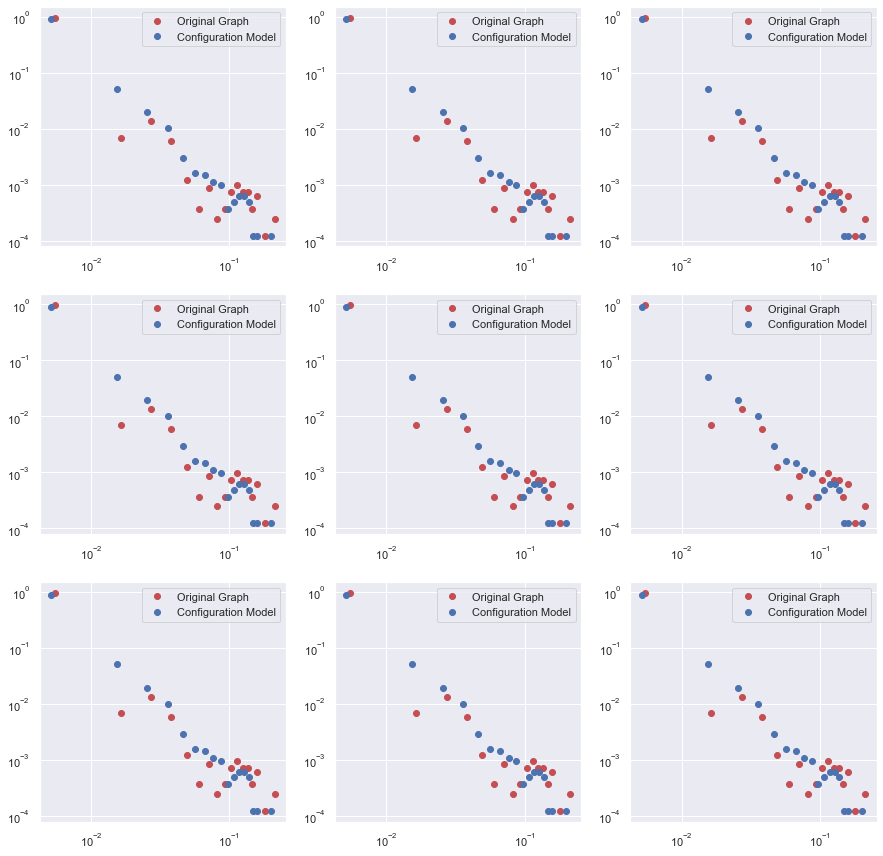

In [30]:
plotter('centrality("eigenvector", ay)')

<a id='fitting'></a>

### Fitting


We do some fitting yeah.

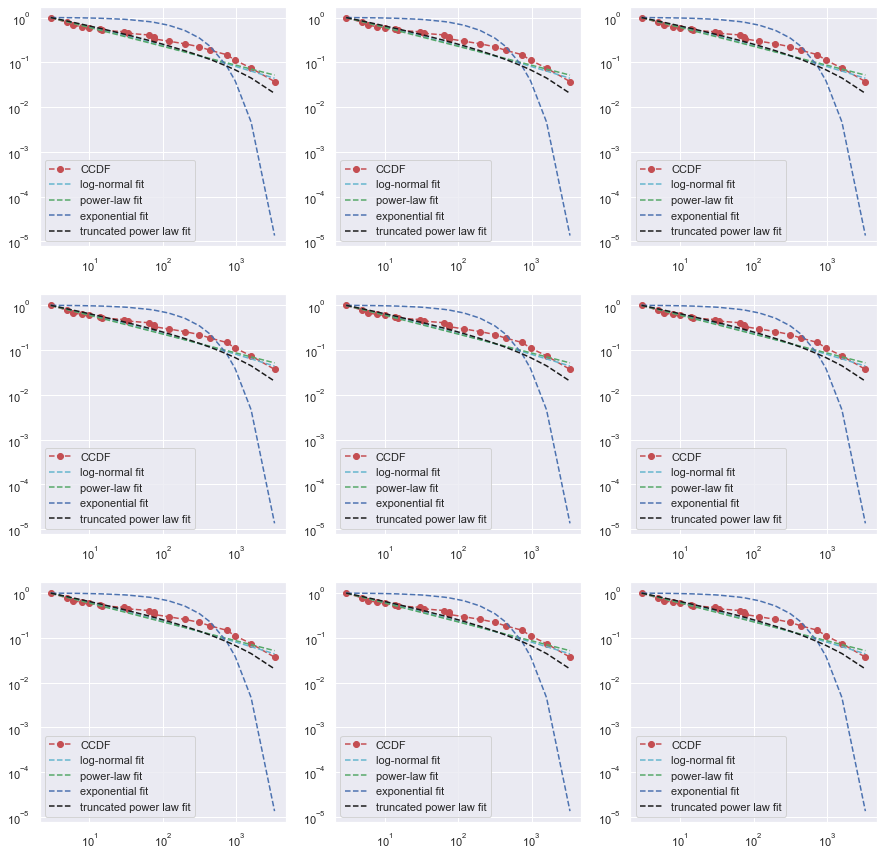

In [22]:
def fitting(ay):
    _, y = D[i]['degs']['in']
    y = np.array(y); mask = y >= 3
    fit = powerlaw.Fit(y[mask], ax=ay, verbose=False)
    fit.plot_ccdf(ax=ay, label='CCDF', color='r', linestyle='--', marker='o')
    fit.lognormal.plot_ccdf(ax=ay, color='c', linestyle='--', label='log-normal fit')
    fit.power_law.plot_ccdf(ax=ay, color='g', linestyle='--', label='power-law fit')
    fit.exponential.plot_ccdf(ax=ay, color='b', linestyle='--', label='exponential fit')
    fit.truncated_power_law.plot_ccdf(ax=ay, color='k', linestyle='--', label='truncated power law fit')

plotter('fitting(ay)')

Thoughts about the fitting

<a id='robustness'></a>

### Robustness


Cursory research on the Gnutella network describes it as inefficient and problematic
Robustness is thus intersting

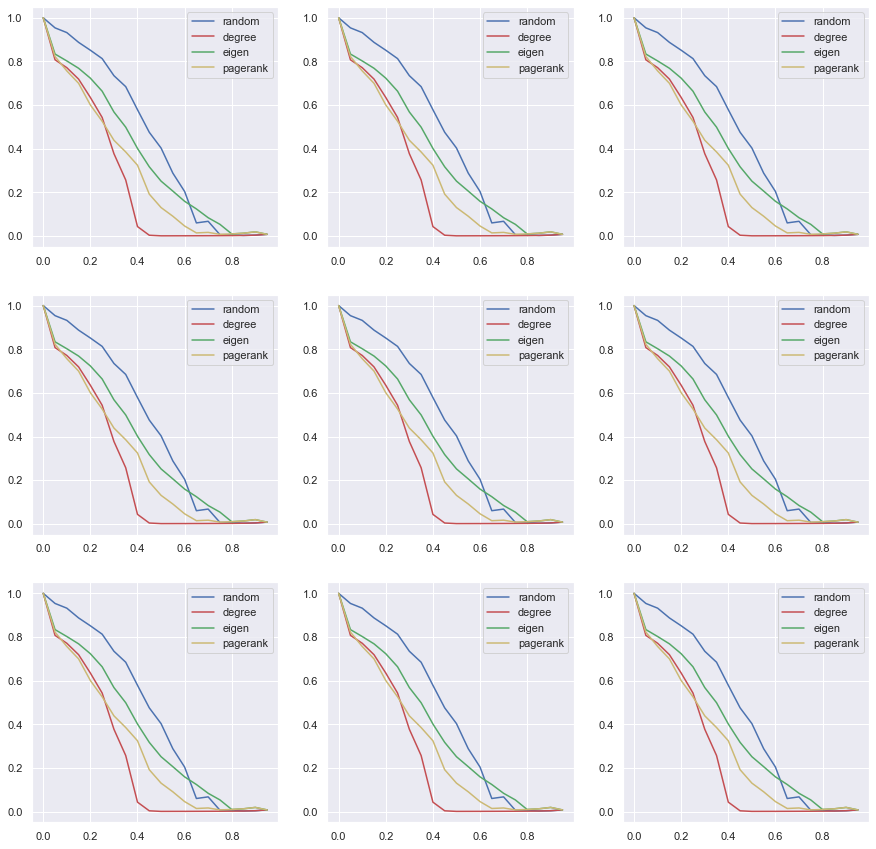

In [29]:
def robustness(ay):
    kinds = ['random', 'degree', 'eigen', 'pagerank']; colors = 'brgy'
    G = D[i]['attack']
    for j in range(len(G) - 1):
        exec(f"ay.plot(G[-1], G[j], colors[j], label='{kinds[j]}')")

plotter('robustness(ay)')